In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
stock_df = pd.read_csv("stock_sentiment.csv")
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [3]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
unique_sentiments_count = stock_df['Sentiment'].value_counts().shape[0]
unique_sentiments_count

2

DATA CLEANING

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
def remove_punctuation(message):
    message_without_punctuation = [char for char in message if char not in string.punctuation]
    message_cleaned = ''.join(message_without_punctuation)
    return message_cleaned

In [7]:
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punctuation)

In [8]:
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [9]:
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])
     

In [11]:
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 2 and token not in stop_words:
            result.append(token)

    return result
     

In [12]:
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess_text)

In [13]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[oi]
...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, rs, investors, book, prof..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."


In [14]:
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))
     

In [15]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[oi],oi
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, rs, investors, book, prof...",gold prices slip rs investors book profits ami...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


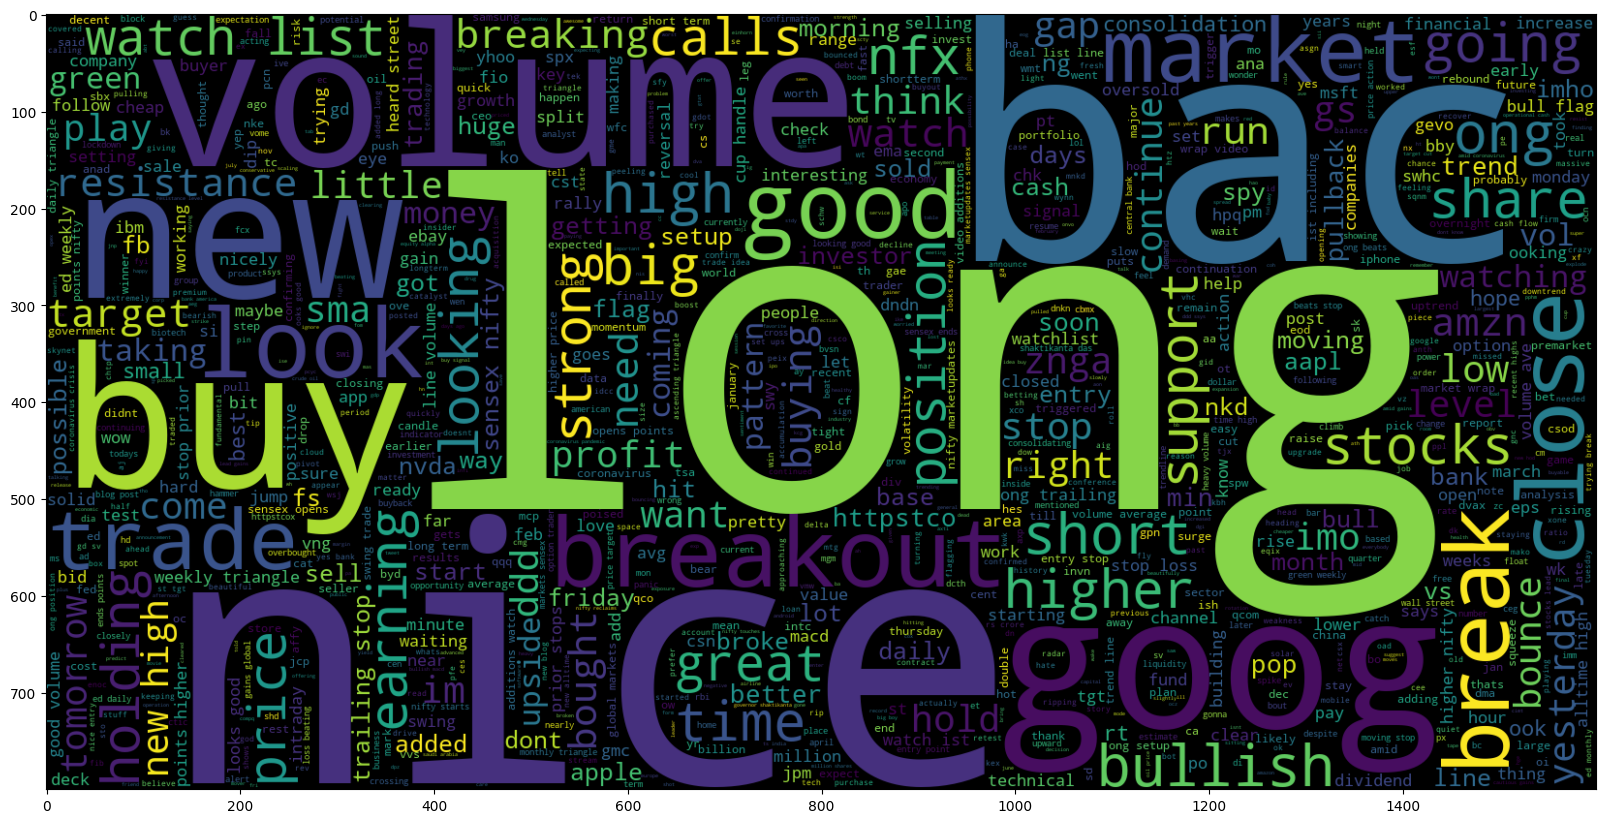

In [16]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear')
     

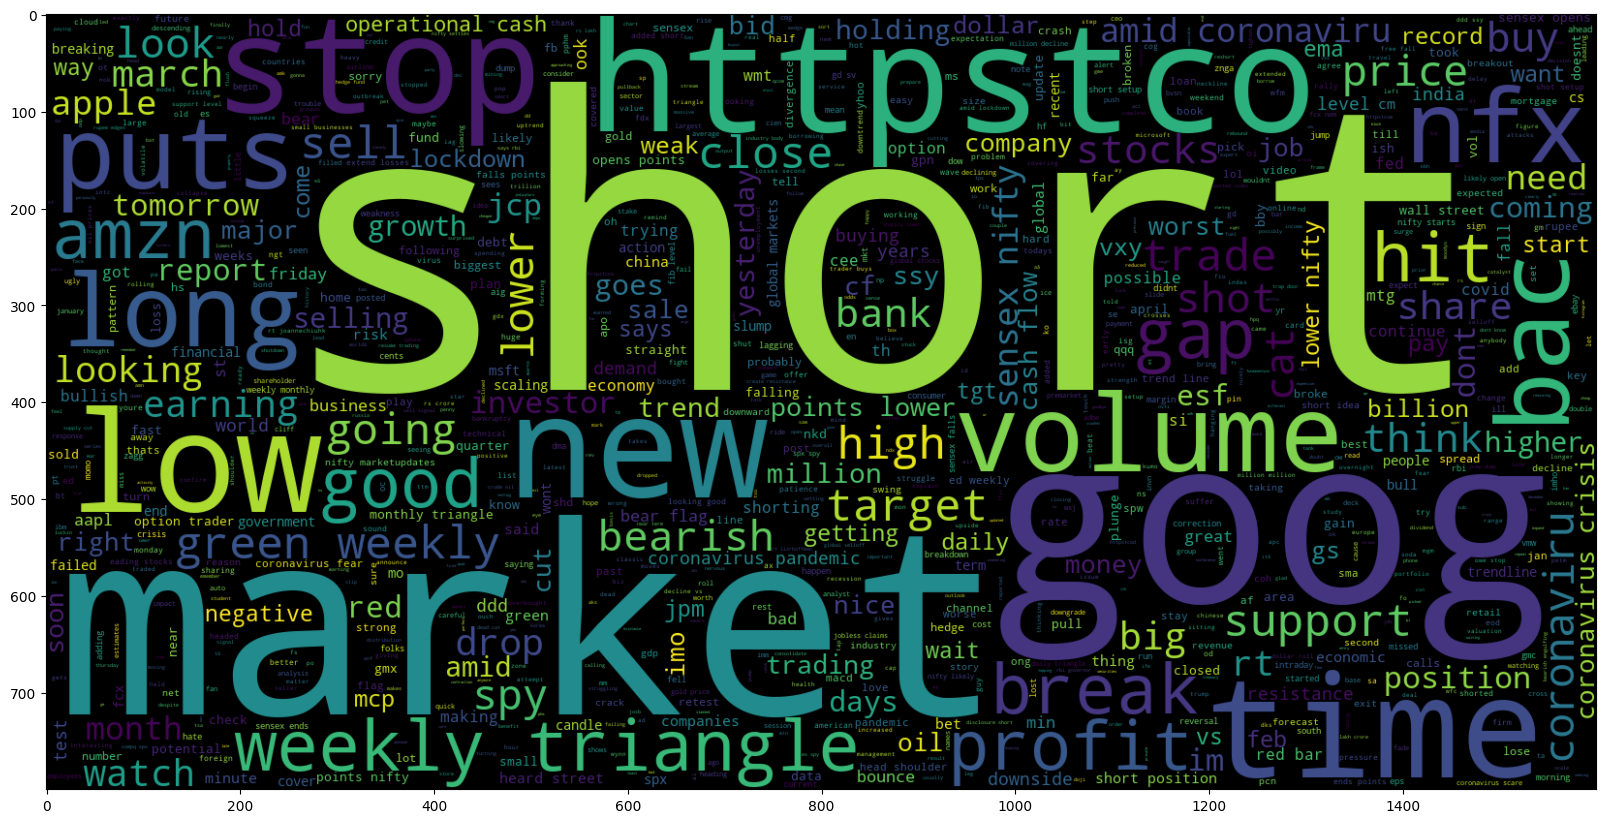

In [17]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear')

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz aj trade method method prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', 'method', 'prev', 'posts']


In [20]:
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 22


In [21]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 8,
 1,
 1,
 1,
 7,
 13,
 8,
 4,
 9,
 14,
 8,
 8,
 10,
 6,
 12,
 8,
 12,
 4,
 6,
 4,
 1,
 5,
 3,
 10,
 3,
 4,
 9,
 6,
 6,
 8,
 7,
 3,
 10,
 10,
 4,
 8,
 11,
 9,
 9,
 3,
 9,
 6,
 5,
 10,
 8,
 4,
 8,
 9,
 11,
 9,
 7,
 2,
 16,
 11,
 9,
 8,
 2,
 15,
 7,
 10,
 4,
 17,
 7,
 7,
 6,
 5,
 6,
 7,
 9,
 4,
 8,
 13,
 19,
 7,
 8,
 7,
 3,
 9,
 5,
 4,
 9,
 9,
 17,
 4,
 9,
 6,
 6,
 2,
 1,
 7,
 10,
 3,
 7,
 7,
 7,
 8,
 1,
 4,
 8,
 4,
 14,
 9,
 10,
 9,
 18,
 6,
 7,
 12,
 10,
 7,
 3,
 4,
 10,
 10,
 7,
 7,
 8,
 5,
 5,
 7,
 10,
 13,
 2,
 4,
 8,
 15,
 15,
 10,
 3,
 1,
 1,
 3,
 7,
 12,
 11,
 10,
 9,
 12,
 10,
 11,
 14,
 6,
 7,
 9,
 11,
 9,
 6,
 12,
 10,
 4,
 8,
 8,
 12,
 11,
 7,
 12,
 4,
 5,
 3,
 7,
 3,
 5,
 9,
 4,
 6,
 10,
 5,
 15,
 7,
 5,
 5,
 9,
 9,
 8,
 8,
 2,
 9,
 9,
 8,
 11,
 9,
 8,
 6,
 3,
 6,
 5,
 8,
 9,
 4,
 6,
 7,
 4,
 4,
 7,
 10,
 9,
 8,
 10,
 9,
 10,
 9,
 12,
 9,
 6,
 5,
 3,
 12,
 13,
 7,
 10,
 9,
 14,
 10,
 6,
 6,
 7,
 10,
 10,
 3,
 3,
 2,
 10,
 3,
 9,
 8,
 15,
 10,
 9,
 14,
 6,
 8,
 2,


In [22]:
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

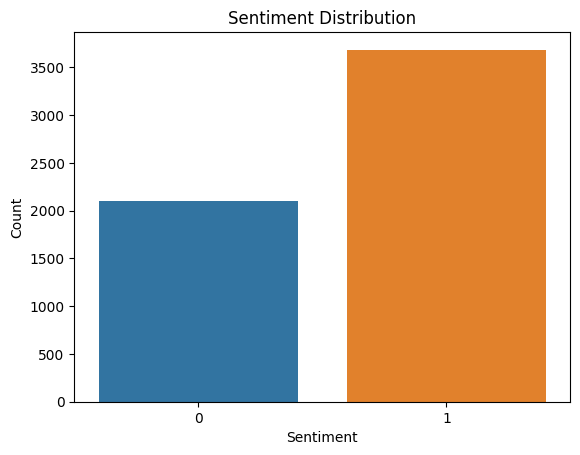

In [23]:
sns.countplot(x='Sentiment', data=stock_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [24]:
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [25]:
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'aj',
 'trade',
 'method',
 'method',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'id',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'oi',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'im',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'like',
 'setup',
 'worries',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'time',
 'shall',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'cheap',
 'great',
 'video',
 'maykiljil',
 'posted',
 'agre

In [26]:
total_words = len(list(set(list_of_words)))
total_words

9487

In [27]:
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [28]:
X_train.shape

(5211,)

In [29]:
X_test.shape

(580,)

In [30]:
X_train

4765                   [cf, trying, bounce, ish, st, tgt]
5206    [secâ, clayton, says, companies, disclose, nee...
3749    [mtg, yesterdays, session, todays, pm, entire,...
4730    [failing, minute, apple, ndx, qqq, fakeout, da...
3013        [play, wait, adding, spw, adding, scty, dips]
                              ...                        
2626    [holding, horz, support, bb, squeeze, rising, ...
380                     [ax, looks, good, higher, prices]
3162    [spw, weve, come, love, returns, significantly...
3064                     [trade, ideas, tif, psn, fshort]
460     [support, broken, wont, hesitate, sell, lots, ...
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [31]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [32]:
train_sequences

[[173, 116, 96, 299, 164, 117],
 [2527, 2528, 141, 201, 3746, 170, 2529, 349, 1940, 3747],
 [300, 669, 851, 367, 406, 1307, 765, 578, 368],
 [1558, 428, 91, 1108, 321, 3748, 67],
 [142, 202, 275, 257, 275, 1109, 766],
 [2530, 135, 26, 208, 3749, 23, 49, 21],
 [301, 350, 230, 322],
 [970, 3750, 3751, 1559, 767, 54, 3752, 62, 2531, 489, 7, 1308, 1110],
 [8, 84, 62, 971],
 [170, 852, 1560, 3753, 2532, 3754, 3755, 10, 1561],
 [768, 3, 530, 48, 1309, 2533],
 [244, 10, 388, 10, 209, 3756, 3757, 135],
 [19, 24, 143, 130, 851, 1310, 45, 1941, 323, 3758, 3759],
 [31, 22, 16, 2534, 17, 47, 323, 17, 1],
 [42, 1942, 324, 612, 1562, 2535, 3760, 92, 210, 97, 490, 3761, 3762, 1563],
 [7, 769, 5, 491, 1943, 1111],
 [19, 24, 143, 93, 258, 455, 1564, 3763],
 [80, 22, 16, 3764, 3765],
 [2536, 21, 853, 670],
 [56, 89, 25, 7],
 [2537, 10, 211, 23, 1565],
 [972],
 [66, 52, 86],
 [531, 236, 854, 429, 67, 1112, 118, 182, 5, 119],
 [29, 1566, 11, 144, 155, 671, 30],
 [2538, 1944, 3766, 3767, 136, 2539, 3768, 3

In [33]:
test_sequences

[[1110, 66],
 [3261, 1487],
 [2482, 1151, 289, 3479, 3442, 863, 3290, 209, 1032, 1154],
 [829, 564, 4, 8, 327, 83, 54, 423, 242, 1140, 165],
 [571, 15, 33, 1192, 69],
 [71, 22],
 [345, 39, 419, 199, 842, 1, 115],
 [44, 981, 12, 25, 100, 391, 505],
 [501, 47, 102, 315, 280, 3959, 1124, 2, 447],
 [4230, 158, 514, 107],
 [10],
 [8, 732],
 [1034, 60, 270, 974, 576, 3640, 1698, 60],
 [9, 296, 1556, 15, 4],
 [44, 196, 137, 3062, 354, 28, 7187, 214],
 [52, 236, 366, 1111, 68, 54, 1754, 314, 73, 974, 499, 377],
 [828, 330, 99, 2, 13],
 [301, 789, 109, 405],
 [14, 190, 1988, 341, 1072, 421, 682, 616, 37],
 [1110, 6, 2997, 3268],
 [95, 315, 758, 49],
 [8719, 1784, 2358, 512, 4849, 7053, 1495, 337, 221, 8680, 475, 2292],
 [5686, 93, 3606, 1151, 26, 4, 626, 28],
 [63, 10, 135, 465, 32],
 [68, 4],
 [577, 25, 6077],
 [264, 392, 122, 1075],
 [3364, 1227, 398, 2633, 2633, 1057, 1058, 4485],
 [1203, 1044, 1105, 1380, 5, 393],
 [29, 308, 1104, 3, 1604],
 [7, 10, 502],
 [134, 5247, 799],
 [2278],
 [603, 

In [34]:
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [35]:
padded_train[:3]

array([[ 173,  116,   96,  299,  164,  117,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [2527, 2528,  141,  201, 3746,  170, 2529,  349, 1940, 3747,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 300,  669,  851,  367,  406, 1307,  765,  578,  368,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [36]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [37]:
y_train_cat

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [38]:
y_train_cat.shape

(5211, 2)

In [39]:
y_test_cat.shape

(580, 2)

In [40]:
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [41]:

model = Sequential()
model.add(Embedding(total_words, output_dim = 512))
model.add(LSTM(256))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         4857344   
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5677954 (21.66 MB)
Trainable params: 5677954 (21.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(padded_train, y_train_cat, batch_size=32, validation_split=0.2, epochs=5, callbacks=[early_stopping])

Epoch 1/5
131/131 [==============================] - 25s 179ms/step - loss: 0.5746 - acc: 0.6975 - val_loss: 0.4870 - val_acc: 0.7728
Epoch 2/5
131/131 [==============================] - 22s 164ms/step - loss: 0.2777 - acc: 0.8966 - val_loss: 0.4908 - val_acc: 0.7699
Epoch 3/5
131/131 [==============================] - 21s 163ms/step - loss: 0.1469 - acc: 0.9487 - val_loss: 0.8152 - val_acc: 0.7574
Epoch 4/5
131/131 [==============================] - 21s 163ms/step - loss: 0.0987 - acc: 0.9652 - val_loss: 0.8023 - val_acc: 0.7488


In [43]:
model_v2 = Sequential()
model_v2.add(Embedding(total_words, output_dim = 256))
model_v2.add(Bidirectional(LSTM(128)))
model_v2.add(Dense(128, activation = 'relu'))
model_v2.add(Dense(2,activation = 'sigmoid'))
model_v2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         2428672   
                                                                 
 bidirectional (Bidirection  (None, 256)               394240    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2856066 (10.90 MB)
Trainable params: 2856066 (10.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_v2.fit(padded_train, y_train_cat, batch_size=32, validation_split=0.2, epochs=5, callbacks=[early_stopping])
     

Epoch 1/5
131/131 [==============================] - 13s 76ms/step - loss: 0.5719 - acc: 0.7073 - val_loss: 0.4817 - val_acc: 0.7546
Epoch 2/5
131/131 [==============================] - 9s 68ms/step - loss: 0.2709 - acc: 0.8896 - val_loss: 0.5395 - val_acc: 0.7632
Epoch 3/5
131/131 [==============================] - 9s 67ms/step - loss: 0.1193 - acc: 0.9571 - val_loss: 0.8748 - val_acc: 0.7603
Epoch 4/5
131/131 [==============================] - 9s 68ms/step - loss: 0.0663 - acc: 0.9746 - val_loss: 1.0080 - val_acc: 0.7498


In [45]:
pred = model.predict(padded_test)

19/19 [==============================] - 1s 21ms/step


In [46]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [47]:
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [48]:
accuracy = accuracy_score(original, prediction)
accuracy

0.7120689655172414

<Axes: >

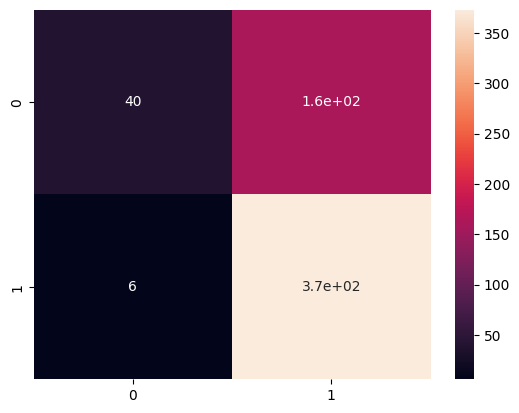

In [49]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)